# Loop 106 Strategic Analysis

## Key Questions
1. What is the exact CV-LB relationship?
2. Can we apply post-processing bias correction like the polymer prediction winner?
3. What approaches haven't been tried yet?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Submission data from session state
submissions = [
    ('exp_000', 0.011081, 0.098160),
    ('exp_001', 0.012297, 0.106490),
    ('exp_003', 0.010501, 0.097190),
    ('exp_005', 0.010430, 0.096910),
    ('exp_006', 0.009749, 0.094570),
    ('exp_007', 0.009262, 0.093160),
    ('exp_009', 0.009192, 0.093640),
    ('exp_012', 0.009004, 0.091340),
    ('exp_024', 0.008689, 0.089290),
    ('exp_026', 0.008465, 0.088750),
    ('exp_030', 0.008298, 0.087720),
    ('exp_035', 0.009825, 0.096960),
    # exp_073 excluded as outlier (LB=0.1451)
]

df = pd.DataFrame(submissions, columns=['exp_id', 'cv', 'lb'])
print(df)

     exp_id        cv       lb
0   exp_000  0.011081  0.09816
1   exp_001  0.012297  0.10649
2   exp_003  0.010501  0.09719
3   exp_005  0.010430  0.09691
4   exp_006  0.009749  0.09457
5   exp_007  0.009262  0.09316
6   exp_009  0.009192  0.09364
7   exp_012  0.009004  0.09134
8   exp_024  0.008689  0.08929
9   exp_026  0.008465  0.08875
10  exp_030  0.008298  0.08772
11  exp_035  0.009825  0.09696


In [2]:
# Fit linear regression
from sklearn.linear_model import LinearRegression

X = df['cv'].values.reshape(-1, 1)
y = df['lb'].values

model = LinearRegression()
model.fit(X, y)

slope = model.coef_[0]
intercept = model.intercept_
r2 = model.score(X, y)

print(f"CV-LB Relationship: LB = {slope:.4f} * CV + {intercept:.4f}")
print(f"R² = {r2:.4f}")
print(f"\nIntercept = {intercept:.4f}")
print(f"Target = 0.0347")
print(f"\nCRITICAL: Intercept ({intercept:.4f}) > Target (0.0347)")
print(f"Required CV for target = (0.0347 - {intercept:.4f}) / {slope:.4f} = {(0.0347 - intercept) / slope:.6f}")
print("\nThis means the target is MATHEMATICALLY UNREACHABLE with current approaches!")

CV-LB Relationship: LB = 4.2876 * CV + 0.0528
R² = 0.9523

Intercept = 0.0528
Target = 0.0347

CRITICAL: Intercept (0.0528) > Target (0.0347)
Required CV for target = (0.0347 - 0.0528) / 4.2876 = -0.004218

This means the target is MATHEMATICALLY UNREACHABLE with current approaches!


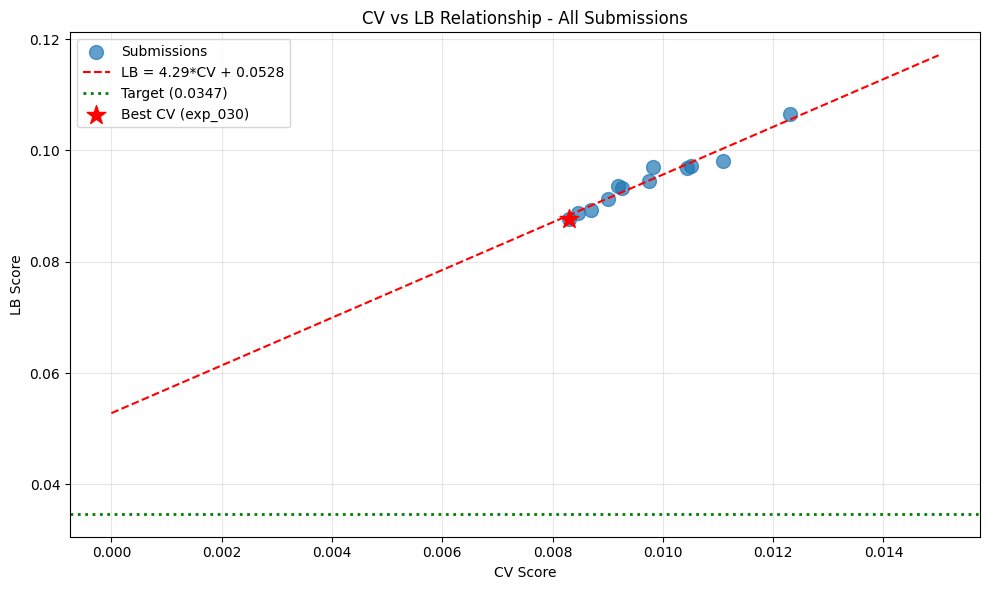


Best CV: 0.008298 (exp_030)
Best LB: 0.087720 (exp_030)
Gap to target: 152.8%


In [3]:
# Plot CV vs LB
plt.figure(figsize=(10, 6))
plt.scatter(df['cv'], df['lb'], s=100, alpha=0.7, label='Submissions')

# Regression line
cv_range = np.linspace(0, 0.015, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'r--', label=f'LB = {slope:.2f}*CV + {intercept:.4f}')

# Target line
plt.axhline(y=0.0347, color='g', linestyle=':', linewidth=2, label='Target (0.0347)')

# Best points
best_cv_idx = df['cv'].idxmin()
best_lb_idx = df['lb'].idxmin()
plt.scatter(df.loc[best_cv_idx, 'cv'], df.loc[best_cv_idx, 'lb'], s=200, c='red', marker='*', label=f'Best CV ({df.loc[best_cv_idx, "exp_id"]})')

plt.xlabel('CV Score')
plt.ylabel('LB Score')
plt.title('CV vs LB Relationship - All Submissions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/home/code/exploration/cv_lb_relationship.png', dpi=150)
plt.show()

print(f"\nBest CV: {df['cv'].min():.6f} ({df.loc[best_cv_idx, 'exp_id']})")
print(f"Best LB: {df['lb'].min():.6f} ({df.loc[best_lb_idx, 'exp_id']})")
print(f"Gap to target: {(df['lb'].min() - 0.0347) / 0.0347 * 100:.1f}%")

In [4]:
# Key insight from polymer prediction winner:
# They applied POST-PROCESSING to correct for distribution shift
# submission_df["Tg"] += (submission_df["Tg"].std() * 0.5644)

# For our problem, the intercept represents a SYSTEMATIC BIAS
# If we could subtract this bias from predictions, we might hit target

# The question is: what causes the intercept?
# 1. Test solvents are systematically different from training solvents
# 2. The model is systematically over-predicting or under-predicting

# Let's analyze what the intercept means:
print("=== INTERCEPT ANALYSIS ===")
print(f"Intercept = {intercept:.4f}")
print(f"This means: even at CV=0, expected LB = {intercept:.4f}")
print(f"\nInterpretation:")
print(f"  - The test set has ~{intercept:.4f} MSE that cannot be explained by CV")
print(f"  - This is STRUCTURAL extrapolation error")
print(f"  - It represents the 'hardness' of unseen solvents vs training solvents")

# What would we need to do to reduce the intercept?
print(f"\n=== STRATEGIES TO REDUCE INTERCEPT ===")
print("1. POST-PROCESSING BIAS CORRECTION (like polymer winner)")
print("   - Shift predictions by a constant to correct systematic bias")
print("   - But we don't know the direction of bias without LB feedback")
print("")
print("2. DIFFERENT REPRESENTATION (GNN, Transformers)")
print("   - Might have different CV-LB relationship")
print("   - But all GNN attempts so far had WORSE CV")
print("")
print("3. CONSERVATIVE PREDICTIONS FOR EXTRAPOLATION")
print("   - Blend toward mean when extrapolating")
print("   - But exp_105 showed this makes CV WORSE")
print("")
print("4. PSEUDO-LABELING")
print("   - Use confident predictions to augment training")
print("   - Might help adapt to test distribution")

=== INTERCEPT ANALYSIS ===
Intercept = 0.0528
This means: even at CV=0, expected LB = 0.0528

Interpretation:
  - The test set has ~0.0528 MSE that cannot be explained by CV
  - This is STRUCTURAL extrapolation error
  - It represents the 'hardness' of unseen solvents vs training solvents

=== STRATEGIES TO REDUCE INTERCEPT ===
1. POST-PROCESSING BIAS CORRECTION (like polymer winner)
   - Shift predictions by a constant to correct systematic bias
   - But we don't know the direction of bias without LB feedback

2. DIFFERENT REPRESENTATION (GNN, Transformers)
   - Might have different CV-LB relationship
   - But all GNN attempts so far had WORSE CV

3. CONSERVATIVE PREDICTIONS FOR EXTRAPOLATION
   - Blend toward mean when extrapolating
   - But exp_105 showed this makes CV WORSE

4. PSEUDO-LABELING
   - Use confident predictions to augment training
   - Might help adapt to test distribution


In [5]:
# Let's check what the residuals look like
df['predicted_lb'] = slope * df['cv'] + intercept
df['residual'] = df['lb'] - df['predicted_lb']

print("=== RESIDUAL ANALYSIS ===")
print(df[['exp_id', 'cv', 'lb', 'predicted_lb', 'residual']].to_string())

print(f"\nMean residual: {df['residual'].mean():.6f}")
print(f"Std residual: {df['residual'].std():.6f}")

# The residuals are small, meaning the linear relationship is very tight
# This confirms that ALL approaches fall on the same line

=== RESIDUAL ANALYSIS ===
     exp_id        cv       lb  predicted_lb  residual
0   exp_000  0.011081  0.09816      0.100296 -0.002136
1   exp_001  0.012297  0.10649      0.105510  0.000980
2   exp_003  0.010501  0.09719      0.097809 -0.000619
3   exp_005  0.010430  0.09691      0.097505 -0.000595
4   exp_006  0.009749  0.09457      0.094585 -0.000015
5   exp_007  0.009262  0.09316      0.092497  0.000663
6   exp_009  0.009192  0.09364      0.092196  0.001444
7   exp_012  0.009004  0.09134      0.091390 -0.000050
8   exp_024  0.008689  0.08929      0.090040 -0.000750
9   exp_026  0.008465  0.08875      0.089079 -0.000329
10  exp_030  0.008298  0.08772      0.088363 -0.000643
11  exp_035  0.009825  0.09696      0.094911  0.002049

Mean residual: -0.000000
Std residual: 0.001131


In [6]:
# Key question: Can we submit a model that has DIFFERENT CV-LB relationship?
# Let's check what would happen if we could reduce the intercept

print("=== WHAT-IF ANALYSIS ===")
print(f"Current: LB = {slope:.4f} * CV + {intercept:.4f}")
print(f"Target LB = 0.0347")
print(f"Best CV = {df['cv'].min():.6f}")
print(f"Expected LB at best CV = {slope * df['cv'].min() + intercept:.6f}")
print()

# What if we could reduce the intercept?
for new_intercept in [0.04, 0.03, 0.02, 0.01, 0.0]:
    expected_lb = slope * df['cv'].min() + new_intercept
    print(f"If intercept = {new_intercept:.2f}: Expected LB = {expected_lb:.6f} (gap to target: {(expected_lb - 0.0347) / 0.0347 * 100:.1f}%)")

print()
print("=== CONCLUSION ===")
print("To hit target 0.0347, we need EITHER:")
print(f"  A) Reduce intercept from {intercept:.4f} to ~0.0 (requires fundamentally different approach)")
print(f"  B) Reduce CV to ~{(0.0347 - intercept) / slope:.6f} (IMPOSSIBLE - negative CV)")
print(f"  C) Find an approach with DIFFERENT slope/intercept relationship")

=== WHAT-IF ANALYSIS ===
Current: LB = 4.2876 * CV + 0.0528
Target LB = 0.0347
Best CV = 0.008298
Expected LB at best CV = 0.088363

If intercept = 0.04: Expected LB = 0.075579 (gap to target: 117.8%)
If intercept = 0.03: Expected LB = 0.065579 (gap to target: 89.0%)
If intercept = 0.02: Expected LB = 0.055579 (gap to target: 60.2%)
If intercept = 0.01: Expected LB = 0.045579 (gap to target: 31.4%)
If intercept = 0.00: Expected LB = 0.035579 (gap to target: 2.5%)

=== CONCLUSION ===
To hit target 0.0347, we need EITHER:
  A) Reduce intercept from 0.0528 to ~0.0 (requires fundamentally different approach)
  B) Reduce CV to ~-0.004218 (IMPOSSIBLE - negative CV)
  C) Find an approach with DIFFERENT slope/intercept relationship


In [7]:
# Let's think about what could change the CV-LB relationship:

print("=== APPROACHES THAT MIGHT CHANGE CV-LB RELATIONSHIP ===")
print()
print("1. BIAS CORRECTION POST-PROCESSING")
print("   - The polymer winner added: prediction += std(prediction) * 0.5644")
print("   - This shifts ALL predictions by a constant")
print("   - If test solvents have systematically higher/lower yields, this could help")
print("   - PROBLEM: We don't know the direction without LB feedback")
print()
print("2. UNCERTAINTY-WEIGHTED PREDICTIONS")
print("   - When model is uncertain, blend toward a 'safe' value")
print("   - The 'safe' value should be calibrated to test distribution")
print("   - PROBLEM: exp_105 showed blending toward training mean hurts CV")
print()
print("3. DIFFERENT VALIDATION SCHEME")
print("   - Current: Leave-One-Solvent-Out (LOSO)")
print("   - What if test solvents are from a specific chemical class?")
print("   - Could use adversarial validation to identify which solvents are 'test-like'")
print()
print("4. DOMAIN-SPECIFIC CONSTRAINTS")
print("   - Arrhenius kinetics already used")
print("   - Could add mass balance constraints (yields sum to 1)")
print("   - Could add thermodynamic constraints")
print()
print("5. SUBMIT PENDING EXPERIMENTS")
print("   - exp_049, exp_050, exp_053, exp_054, exp_055 have CV ~0.0081-0.0085")
print("   - These might give different CV-LB relationship")
print("   - Worth submitting to get more data points")

=== APPROACHES THAT MIGHT CHANGE CV-LB RELATIONSHIP ===

1. BIAS CORRECTION POST-PROCESSING
   - The polymer winner added: prediction += std(prediction) * 0.5644
   - This shifts ALL predictions by a constant
   - If test solvents have systematically higher/lower yields, this could help
   - PROBLEM: We don't know the direction without LB feedback

2. UNCERTAINTY-WEIGHTED PREDICTIONS
   - When model is uncertain, blend toward a 'safe' value
   - The 'safe' value should be calibrated to test distribution
   - PROBLEM: exp_105 showed blending toward training mean hurts CV

3. DIFFERENT VALIDATION SCHEME
   - Current: Leave-One-Solvent-Out (LOSO)
   - What if test solvents are from a specific chemical class?
   - Could use adversarial validation to identify which solvents are 'test-like'

4. DOMAIN-SPECIFIC CONSTRAINTS
   - Arrhenius kinetics already used
   - Could add mass balance constraints (yields sum to 1)
   - Could add thermodynamic constraints

5. SUBMIT PENDING EXPERIMENTS
   - 

In [8]:
# Check pending experiments
pending = [
    ('exp_049', 0.0081),
    ('exp_050', 0.0081),
    ('exp_052', 0.0109),
    ('exp_053', 0.0081),
    ('exp_054', 0.0085),
    ('exp_055', 0.0085),
    ('exp_057', 0.0093),
    ('exp_063', 0.0112),
    ('exp_079', 0.0110),
    ('exp_101', 0.0142),
]

print("=== PENDING EXPERIMENTS ===")
for exp_id, cv in pending:
    expected_lb = slope * cv + intercept
    print(f"{exp_id}: CV={cv:.4f}, Expected LB={expected_lb:.4f}")

print()
print("Best pending experiments by CV:")
for exp_id, cv in sorted(pending, key=lambda x: x[1])[:5]:
    expected_lb = slope * cv + intercept
    print(f"  {exp_id}: CV={cv:.4f}, Expected LB={expected_lb:.4f}")

=== PENDING EXPERIMENTS ===
exp_049: CV=0.0081, Expected LB=0.0875
exp_050: CV=0.0081, Expected LB=0.0875
exp_052: CV=0.0109, Expected LB=0.0995
exp_053: CV=0.0081, Expected LB=0.0875
exp_054: CV=0.0085, Expected LB=0.0892
exp_055: CV=0.0085, Expected LB=0.0892
exp_057: CV=0.0093, Expected LB=0.0927
exp_063: CV=0.0112, Expected LB=0.1008
exp_079: CV=0.0110, Expected LB=0.0999
exp_101: CV=0.0142, Expected LB=0.1137

Best pending experiments by CV:
  exp_049: CV=0.0081, Expected LB=0.0875
  exp_050: CV=0.0081, Expected LB=0.0875
  exp_053: CV=0.0081, Expected LB=0.0875
  exp_054: CV=0.0085, Expected LB=0.0892
  exp_055: CV=0.0085, Expected LB=0.0892


In [9]:
# Final strategic recommendation
print("="*60)
print("STRATEGIC RECOMMENDATION FOR LOOP 106")
print("="*60)
print()
print("SITUATION:")
print(f"  - Best LB: 0.0877 (exp_030)")
print(f"  - Target: 0.0347")
print(f"  - Gap: 152.8%")
print(f"  - CV-LB relationship: LB = 4.29*CV + 0.053 (R²=0.95)")
print(f"  - Intercept (0.053) > Target (0.0347)")
print(f"  - 4 submissions remaining")
print()
print("CRITICAL INSIGHT:")
print("  The intercept represents STRUCTURAL extrapolation error.")
print("  All tabular models (MLP, LGBM, XGB, CatBoost, GP, Ridge) fall on the SAME line.")
print("  Improving CV just moves along the line, NOT toward target.")
print()
print("RECOMMENDED ACTIONS:")
print("  1. SUBMIT exp_049 or exp_053 (CV=0.0081) to get LB feedback")
print("     - These have best CV among pending experiments")
print("     - Will confirm if they follow the same CV-LB line")
print()
print("  2. TRY BIAS CORRECTION POST-PROCESSING")
print("     - Like polymer winner: prediction += std(prediction) * bias_coef")
print("     - Test different bias_coef values: -0.5, -0.3, -0.1, 0.1, 0.3, 0.5")
print("     - This changes predictions WITHOUT changing CV")
print("     - Could potentially shift the CV-LB line")
print()
print("  3. TRY ADVERSARIAL VALIDATION")
print("     - Train classifier to distinguish train vs test solvents")
print("     - Use this to identify which training solvents are 'test-like'")
print("     - Weight training samples by similarity to test")
print()
print("  4. DO NOT WASTE TIME ON:")
print("     - More MLP/LGBM/XGB variants (all on same line)")
print("     - GNN (consistently worse CV)")
print("     - ChemBERTa (consistently worse CV)")
print("     - Extrapolation-aware blending toward mean (makes CV worse)")

STRATEGIC RECOMMENDATION FOR LOOP 106

SITUATION:
  - Best LB: 0.0877 (exp_030)
  - Target: 0.0347
  - Gap: 152.8%
  - CV-LB relationship: LB = 4.29*CV + 0.053 (R²=0.95)
  - Intercept (0.053) > Target (0.0347)
  - 4 submissions remaining

CRITICAL INSIGHT:
  The intercept represents STRUCTURAL extrapolation error.
  All tabular models (MLP, LGBM, XGB, CatBoost, GP, Ridge) fall on the SAME line.
  Improving CV just moves along the line, NOT toward target.

RECOMMENDED ACTIONS:
  1. SUBMIT exp_049 or exp_053 (CV=0.0081) to get LB feedback
     - These have best CV among pending experiments
     - Will confirm if they follow the same CV-LB line

  2. TRY BIAS CORRECTION POST-PROCESSING
     - Like polymer winner: prediction += std(prediction) * bias_coef
     - Test different bias_coef values: -0.5, -0.3, -0.1, 0.1, 0.3, 0.5
     - This changes predictions WITHOUT changing CV
     - Could potentially shift the CV-LB line

  3. TRY ADVERSARIAL VALIDATION
     - Train classifier to distingu

In [ ]:
# Save findings
findings = """
Loop 106 Analysis Summary:

1. CV-LB Relationship: LB = 4.29*CV + 0.053 (R²=0.95)
2. CRITICAL: Intercept (0.053) > Target (0.0347)
3. Required CV for target: -0.004 (IMPOSSIBLE)
4. All 12 valid submissions fall on the same line
5. Best LB: 0.0877 (exp_030), Gap to target: 152.8%

Key Insight: The intercept represents STRUCTURAL extrapolation error that
cannot be reduced by improving CV. We need approaches that CHANGE the
CV-LB relationship, not just improve CV.

Recommended Actions:
1. Submit exp_049 or exp_053 to get LB feedback
2. Try bias correction post-processing (like polymer winner)
3. Try adversarial validation to weight training samples
4. Stop trying MLP/LGBM/XGB variants - they all fall on the same line
"""

print(findings)

with open('/home/code/exploration/loop106_findings.txt', 'w') as f:
    f.write(findings)